<a href="https://colab.research.google.com/github/lucasswolff/Data-Analysis-Projects/blob/main/Ecommerce_analysis_using_SQL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Introduction**

This project was made by Lucas Wolff. The main goal is to make analysis using SQL. 

The data used is from an ecommerce in Brazil. 

The dataset can be found at:
https://www.kaggle.com/olistbr/brazilian-ecommerce

Tools such as Joins, Group By, Windown Functions, CTE and Partittion By was used

The dataset has the following schema:

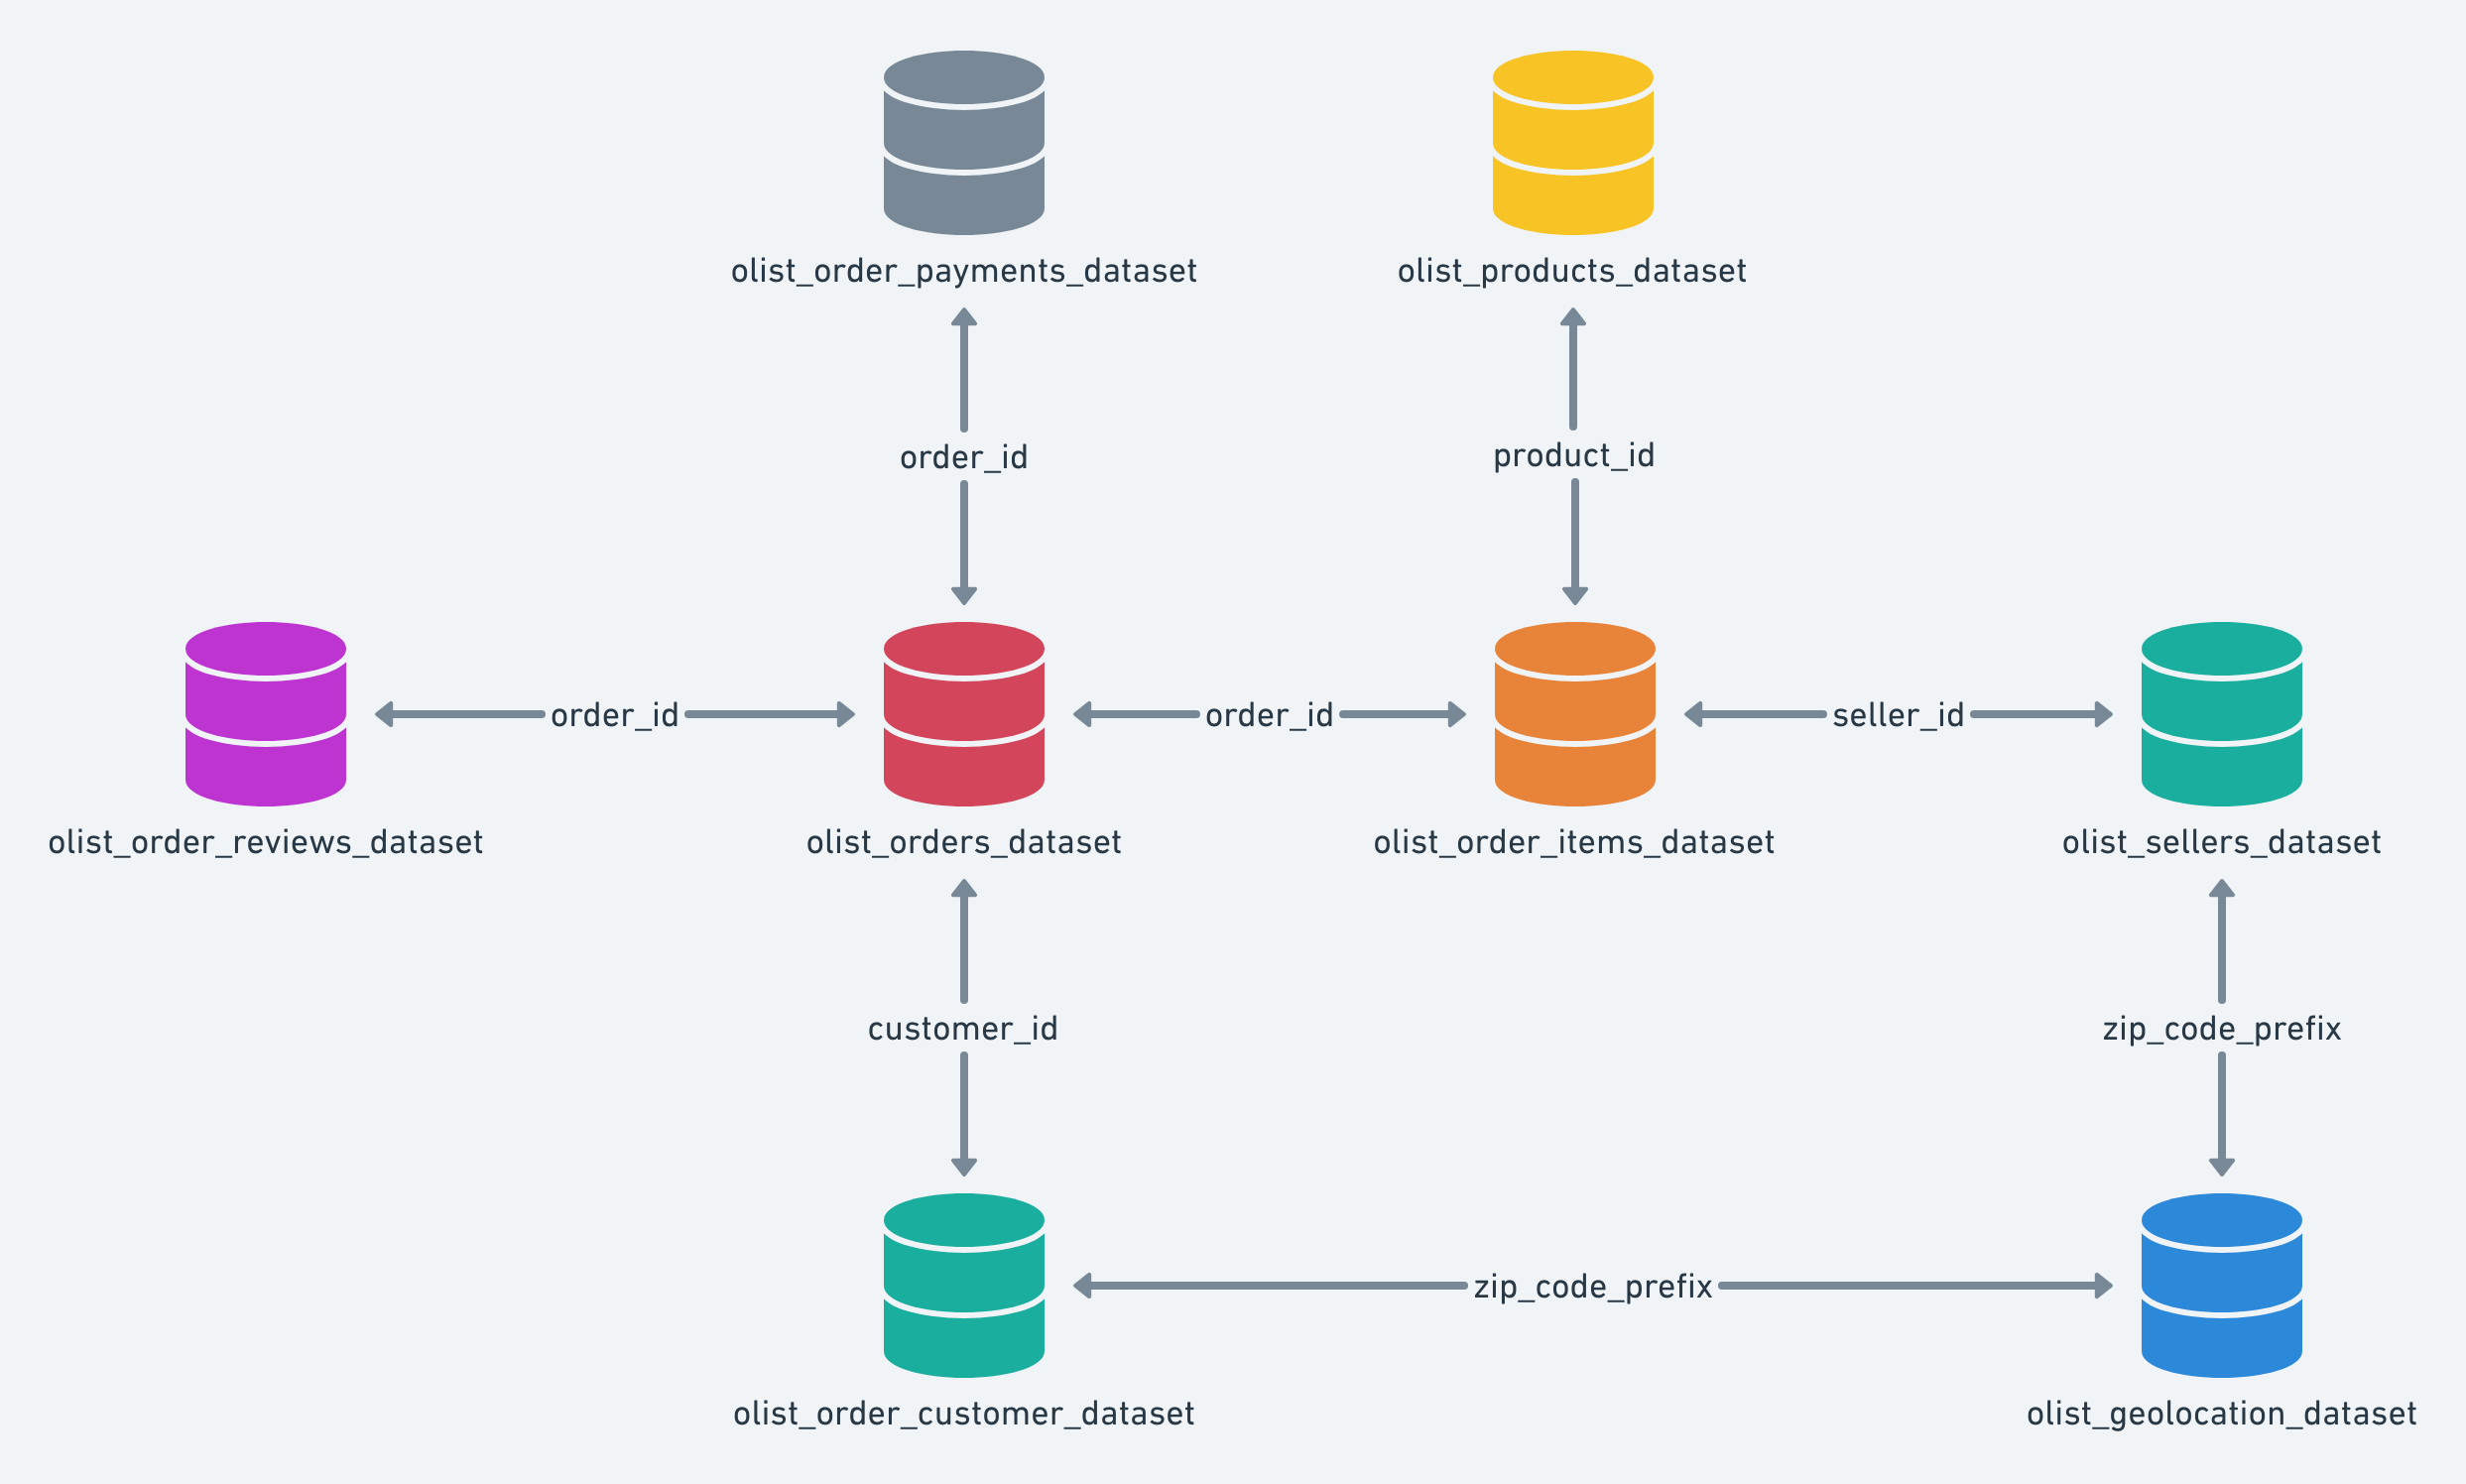

**Importing libraries and the data**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import sqlite3
import pandas as pd

In [3]:
customers = pd.read_csv('/content/drive/MyDrive/Colab Datasets/olist_dataset/olist_customers_dataset.csv')
geolocation = pd.read_csv('/content/drive/MyDrive/Colab Datasets/olist_dataset/olist_geolocation_dataset.csv')
order_items = pd.read_csv('/content/drive/MyDrive/Colab Datasets/olist_dataset/olist_order_items_dataset.csv')
order_reviews = pd.read_csv('/content/drive/MyDrive/Colab Datasets/olist_dataset/olist_order_reviews_dataset.csv')
orders = pd.read_csv('/content/drive/MyDrive/Colab Datasets/olist_dataset/olist_orders_dataset.csv')
payments = pd.read_csv('/content/drive/MyDrive/Colab Datasets/olist_dataset/olist_order_payments_dataset.csv')
product_category_name_translation = pd.read_csv('/content/drive/MyDrive/Colab Datasets/olist_dataset/product_category_name_translation.csv')
products = pd.read_csv('/content/drive/MyDrive/Colab Datasets/olist_dataset/olist_products_dataset.csv')
sellers = pd.read_csv('/content/drive/MyDrive/Colab Datasets/olist_dataset/olist_sellers_dataset.csv')

**Setting SQL**

In [4]:
 !pip install ipython-sql

In [5]:
#creates a database
cnn = sqlite3.connect('olist_dataset.db')

In [6]:
#conects the table to de database
#first argument = name of the table
#cnn = name of the conection
customers.to_sql('customers', cnn)
geolocation.to_sql('geolocation', cnn)
order_items.to_sql('order_items', cnn)
order_reviews.to_sql('order_reviews', cnn)
orders.to_sql('orders', cnn)
payments.to_sql('payments', cnn)
product_category_name_translation.to_sql('product_category_name_translation', cnn)
products.to_sql('products', cnn)
sellers.to_sql('sellers', cnn)

In [7]:
%load_ext sql
%sql sqlite:///olist_dataset.db

'Connected: @olist_dataset.db'

## **Analysis**

**Top 10 cities with the most orders (in volume)**

In [8]:
%%sql

SELECT b.customer_city, COUNT(a.order_id) AS number_of_orders
FROM orders AS a
LEFT JOIN customers AS b
ON a.customer_id = b.customer_id
GROUP BY b.customer_city
ORDER BY number_of_orders DESC
LIMIT 10

 * sqlite:///olist_dataset.db
Done.


customer_city,number_of_orders
sao paulo,15540
rio de janeiro,6882
belo horizonte,2773
brasilia,2131
curitiba,1521
campinas,1444
porto alegre,1379
salvador,1245
guarulhos,1189
sao bernardo do campo,938


**Top 10 cities with the most orders (in revenue)**

Using CTE

In [9]:
%%sql

WITH CTE_order_city AS (
	SELECT a.order_id, b.customer_city
	FROM orders AS a
	LEFT JOIN customers AS b
	ON a.customer_id = b.customer_id
	)
SELECT 
	c.customer_city, 
	SUM(d.order_item_id * (d.price + d.freight_value)) AS total_revenue
FROM CTE_order_city as c
LEFT JOIN order_items as d
ON c.order_id = d.order_id
GROUP BY customer_city
ORDER BY total_revenue DESC
LIMIT 10

 * sqlite:///olist_dataset.db
Done.


customer_city,total_revenue
sao paulo,2506788.8100000117
rio de janeiro,1359991.4900000005
belo horizonte,458946.5200000005
brasilia,391502.8300000003
curitiba,286738.0899999998
porto alegre,269614.0800000003
salvador,252945.67000000016
campinas,239248.79999999952
guarulhos,184848.32999999996
goiania,168136.57999999978


**Top 10 sellers (in volume and revenue)**

In [10]:
%%sql

SELECT seller_id, SUM(order_item_id*price) AS faturamento, COUNT(order_id) AS volume_vendas
FROM order_items 
GROUP BY seller_id
ORDER BY COUNT(order_id) DESC
LIMIT 10

 * sqlite:///olist_dataset.db
Done.


seller_id,faturamento,volume_vendas
6560211a19b47992c3666cc44a7e94c0,133564.81,2033
4a3ca9315b744ce9f8e9374361493884,226871.7199999949,1987
1f50f920176fa81dab994f9023523100,162414.6499999963,1931
cc419e0650a3c5ba77189a1882b7556a,108133.6700000027,1775
da8622b14eb17ae2831f4ac5b9dab84a,197382.1499999954,1551
955fee9216a65b617aa5c0531780ce60,167045.2699999989,1499
1025f0e2d44d7041d6cf58b6550e0bfa,190591.26999999955,1428
7c67e1448b00f6e969d365cea6b010ab,292489.29999999824,1364
ea8482cd71df3c1969d7b9473ff13abc,39443.60000000027,1203
7a67c85e85bb2ce8582c35f2203ad736,144370.29000000143,1171


**State of origin with the most sales**

In [11]:
%%sql

SELECT seller_state, COUNT(seller_id) AS number_of_sellers
FROM sellers
GROUP BY seller_state
ORDER BY COUNT(seller_id) DESC
LIMIT 5

 * sqlite:///olist_dataset.db
Done.


seller_state,number_of_sellers
SP,1849
PR,349
MG,244
SC,190
RJ,171


**Cities with more sells in the South East region**

In [23]:
%%sql

SELECT b.customer_state, b.customer_city, COUNT(a.order_id) AS number_of_orders
FROM orders AS a
LEFT JOIN customers AS b
ON a.customer_id = b.customer_id
GROUP BY b.customer_state, b.customer_city
HAVING b.customer_state IN ('SP','RJ','MG','ES')
ORDER BY COUNT(a.order_id) DESC
LIMIT 15

 * sqlite:///olist_dataset.db
Done.


customer_state,customer_city,number_of_orders
SP,sao paulo,15540
RJ,rio de janeiro,6882
MG,belo horizonte,2773
SP,campinas,1444
SP,guarulhos,1189
SP,sao bernardo do campo,938
RJ,niteroi,849
SP,santo andre,796
SP,osasco,746
SP,santos,713


**Days with the bigger revenue (freight not included)**

In [12]:
%%sql

WITH CTE_price_date AS(
	SELECT DATE(order_purchase_timestamp) AS order_purchase_date, (b.order_item_id*b.price) AS price_amount
	FROM orders AS a
	LEFT JOIN order_items AS b
	ON a.order_id = b.order_id
  WHERE order_approved_at IS NOT NULL --Not all orders payment was approved 
	)
SELECT order_purchase_date, ROUND(SUM(price_amount),2) AS sales
FROM CTE_price_date
GROUP BY order_purchase_date
ORDER BY sales DESC
LIMIT 5

 * sqlite:///olist_dataset.db
Done.


order_purchase_date,sales
2017-11-24,186348.72
2017-09-29,82473.25
2017-11-25,69896.9
2018-08-06,67150.57
2018-08-07,62888.36


**Average revenue by month**

In [13]:
%%sql

WITH CTE_price_date AS(
	SELECT strftime('%m', order_approved_at) AS month_,strftime('%Y', order_approved_at) AS year_, (b.order_item_id*b.price) AS price_amount
	FROM orders AS a
	LEFT JOIN order_items AS b
	ON a.order_id = b.order_id
	),
CTE_sales_month AS(
	SELECT month_, year_, SUM(price_amount) AS sales
	FROM CTE_price_date
	GROUP BY month_, year_
	)
SELECT month_, ROUND(AVG(sales),2) AS average_sales
FROM CTE_sales_month
GROUP BY month_
ORDER BY average_sales DESC

 * sqlite:///olist_dataset.db
Done.


month_,average_sales
11,1160381.63
05,862675.79
08,814684.64
07,771894.84
03,764698.98
04,753740.04
06,729042.19
02,616560.1
01,598825.61
10,436174.94


**Number of orders delivered on time and delayed**

In [14]:
%%sql

WITH CTE_transform_date AS(
	SELECT 
		order_id, 
		DATE(order_estimated_delivery_date) AS estimated_delivery_date,
		DATE(order_delivered_customer_date) AS delivered_customer_date
	FROM orders
	),
CTE_delivery_status AS(
	SELECT order_id, estimated_delivery_date, delivered_customer_date,
		CASE 
			WHEN delivered_customer_date >  estimated_delivery_date THEN 'Delayed'
			WHEN delivered_customer_date =  estimated_delivery_date THEN 'On Time'
			ELSE 'Earlier'
		END AS delivery_status
	FROM CTE_transform_date
	)
SELECT 
	delivery_status, 
	COUNT(order_id) AS count_,
	CAST (COUNT(*)*100.00/(SELECT COUNT(*) FROM CTE_delivery_status) AS decimal(10,2)) AS percentage_
FROM CTE_delivery_status
GROUP BY delivery_status
ORDER BY percentage_ DESC

 * sqlite:///olist_dataset.db
Done.


delivery_status,count_,percentage_
Earlier,91614,92.12900111623978
Delayed,6535,6.571736004263835
On Time,1292,1.2992628794963847


**Biggest price and average price by category**

In [15]:
%%sql

WITH CTE_product_name_id AS (
	SELECT a.order_id, b.product_category_name
	FROM order_items AS a
	LEFT JOIN products AS b
	ON a.product_id = b.product_id
	),
CTE_product_name_en_id AS(
	SELECT c.order_id, d.product_category_name_english
	FROM CTE_product_name_id AS c
	LEFT JOIN product_category_name_translation AS d
	ON c.product_category_name = d.product_category_name
)
SELECT DISTINCT
	e.product_category_name_english, 
	ROUND(MAX(f.price),2) AS max_price, 
	ROUND(AVG(f.price),2) AS average_price, 
	ROUND(SUM(f.price),2) AS total_revenue 
FROM CTE_product_name_en_id AS e
LEFT JOIN order_items AS f
ON e.order_id = f.order_id
GROUP BY e.product_category_name_english
ORDER BY total_revenue DESC

 * sqlite:///olist_dataset.db
Done.


product_category_name_english,max_price,average_price,total_revenue
health_beauty,3124.0,114.97,1434669.29
bed_bath_table,1999.98,87.69,1420357.66
computers_accessories,3699.99,114.65,1365456.66
watches_gifts,3999.9,182.17,1310710.74
sports_leisure,4059.0,105.15,1179385.73
furniture_decor,1899.0,77.03,1138493.8
housewares,6735.0,78.34,872871.82
auto,2258.0,132.65,734323.55
garden_tools,3930.0,92.97,687874.91
cool_stuff,3109.99,156.6,684197.86


The following queries are not working in this version of sqlite. In SQL Server is working just fine. The problems is either because this is an old version or because the sintax is not right for sqlite. A member from Stackoverflow said the sintax is ok

**Top 3 sellers in each category**

Window function ranking

In [23]:
%%sql

WITH CTE_product_name_id AS (
	SELECT a.order_id, a.seller_id, b.product_category_name, (a.price*a.order_item_id) AS revenue
	FROM order_items AS a
	LEFT JOIN products AS b
	ON a.product_id = b.product_id
	),
CTE_product_name_en_id AS(
	SELECT c.order_id, c.seller_id, d.product_category_name_english AS product_category, revenue
	FROM CTE_product_name_id AS c
	LEFT JOIN product_category_name_translation AS d
	ON c.product_category_name = d.product_category_name
	),
CTE_product_seller AS(
	SELECT  product_category, seller_id, SUM(revenue) AS revenue, COUNT(revenue) AS number_of_sales
	FROM CTE_product_name_en_id
	GROUP BY product_category,seller_id
	)
SELECT * FROM (
	SELECT RANK() OVER(PARTITION BY product_category ORDER BY revenue DESC) AS ranking, *
	FROM CTE_product_seller) AS x
WHERE x.ranking <= 3 AND product_category IS NOT NULL
ORDER BY product_category

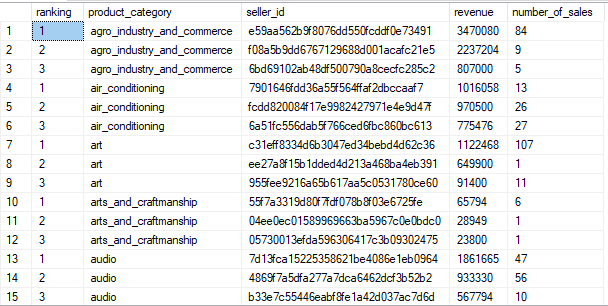

**Pivot table using rollup**

NULL means subtotal or total

In [23]:
%%sql

WITH CTE_product_name_id AS (
	SELECT a.order_id, a.seller_id, b.product_category_name, (a.price*a.order_item_id) AS revenue
	FROM order_items AS a
	LEFT JOIN products AS b
	ON a.product_id = b.product_id
	),
CTE_product_name_en_id AS(
	SELECT c.order_id, c.seller_id, ISNULL (d.product_category_name_english,'others') AS product_category, revenue
	FROM CTE_product_name_id AS c
	LEFT JOIN product_category_name_translation AS d
	ON c.product_category_name = d.product_category_name
	)
SELECT  product_category, seller_id, SUM(revenue) AS revenue, COUNT(revenue) AS number_of_sales
FROM CTE_product_name_en_id
GROUP BY ROLLUP (product_category, seller_id)

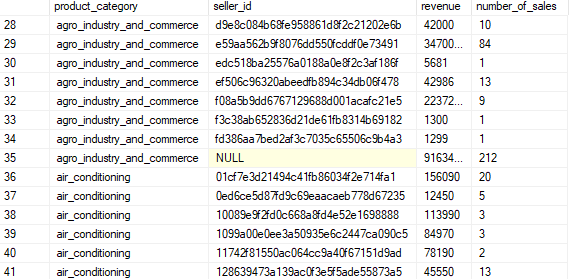

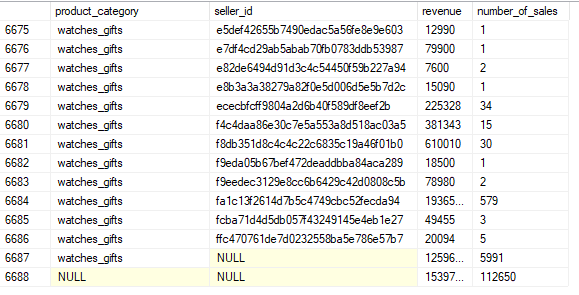

**Using Grouping Sets**

Create subtotals for each column specified. In this case, it calculates a subtotal for each seller and then for each category

In [24]:
%%sql

WITH CTE_product_name_id AS (
	SELECT a.order_id, a.seller_id, b.product_category_name, (a.price*a.order_item_id) AS revenue
	FROM order_items AS a
	LEFT JOIN products AS b
	ON a.product_id = b.product_id
	),
CTE_product_name_en_id AS(
	SELECT c.order_id, c.seller_id, d.product_category_name_english AS product_category, revenue
	FROM CTE_product_name_id AS c
	LEFT JOIN product_category_name_translation AS d
	ON c.product_category_name = d.product_category_name
	)
SELECT  product_category, seller_id, SUM(revenue) AS revenue, COUNT(revenue) AS number_of_sales
FROM CTE_product_name_en_id
GROUP BY GROUPING SETS (product_category, seller_id)

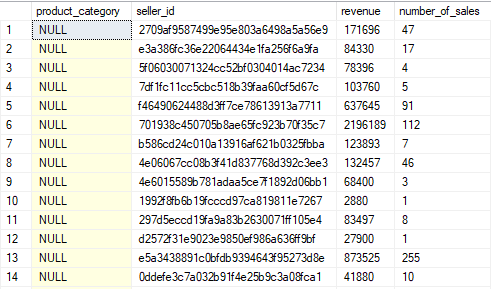

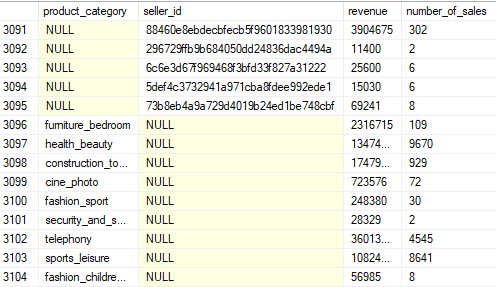

# Creating tables

To create the tables and create the foreign keys, the following queries was used

**Creating tables**

In [ ]:
%%sql

CREATE TABLE customers(
	customer_id varchar(150) PRIMARY KEY NOT NULL,
	customer_unique_id varchar(150),
	customer_zip_code varchar(150),
	customer_city varchar(150),
	customer_state varchar(150)
);

CREATE TABLE geolocation(
	geolocation_zip_code INT PRIMARY KEY NOT NULL,
	geolocation_lat FLOAT,
	geolocation_lng FLOAT,
	geolocation_city varchar (150),
	geolocation_state varchar (150)
);

CREATE TABLE order_items(
	order_id varchar(150) PRIMARY KEY NOT NULL,
	order_item_id INT,
	product_id varchar(150),
	seller_id varchar(150),
	shipping_limit_date datetime,
	price FLOAT,
	freight_value FLOAT
);

CREATE TABLE payments(
	order_id varchar(150) PRIMARY KEY NOT NULL,
	payment_sequential INT,
	payment_type varchar(150),
	payment_installments INT,
	payment_value FLOAT
);

CREATE TABLE order_reviews(
	review_id varchar(150) PRIMARY KEY NOT NULL,
	order_id varchar(150),
	review_score INT,
	review_comment_title varchar(200),
	review_comment_message varchar(1000),
	review_creation_date datetime,
	review_answer_time datetime
);

CREATE TABLE orders(
	order_id varchar(150) PRIMARY KEY NOT NULL,
	customer_id varchar(150),
	order_status varchar(150),
	order_purchase_timestamp datetime,
	order_approved_timestamp datetime,
	order_delivered_carrier_date datetime,
	order_delivered_customer_date datetime,
	order_estimated_delivery_date datetime
);

CREATE TABLE products(
	product_id varchar(150) PRIMARY KEY NOT NULL,
	product_category_name  varchar(150),
	product_name_lenght INT,
	product_description_lenght INT,
	product_photos_q INT,
	product_weight_g FLOAT,
	product_length_cm FLOAT,
	product_height_cm FLOAT,
	product_width_cm FLOAT
);

CREATE TABLE sellers(
	seller_id varchar(150) PRIMARY KEY NOT NULL,
	seller_zip_code_prefix INT,
	seller_city varchar(150),
	seller_state varchar(150)
);


CREATE TABLE category_name_translation(
	product_category_name varchar(150)  PRIMARY KEY NOT NULL,
	product_category_name_english varchar(150)
)

**Creating foreign  keys**

In [ ]:
%%sql

ALTER TABLE customers
	ADD CONSTRAINT fk_Customer_zip_code FOREIGN KEY (customer_zip_code) REFERENCES geolocation(geolocation_zip_code);

ALTER TABLE order_items
	ADD CONSTRAINT fk_Orders_items FOREIGN KEY (order_id) REFERENCES orders (order_id);

ALTER TABLE order_items
	ADD CONSTRAINT fk_Products FOREIGN KEY (product_id) REFERENCES products (product_id);

ALTER TABLE order_items
	ADD CONSTRAINT fk_Sellers FOREIGN KEY (seller_id) REFERENCES sellers (seller_id);

ALTER TABLE payments
	ADD CONSTRAINT fk_Orders_payment FOREIGN KEY (order_id) REFERENCES orders (order_id);

ALTER TABLE order_reviews
	ADD CONSTRAINT fk_Orders_reviews FOREIGN KEY (order_id) REFERENCES orders (order_id);

ALTER TABLE orders
	ADD CONSTRAINT fk_Customer FOREIGN KEY (customer_id) REFERENCES customers (customer_id)

**Dropping Tables**

With necessary, the following query could be used to drop the table

In [ ]:
%sql

DROP TABLE customers;
DROP TABLE geolocation;
DROP TABLE geolocation_;
DROP TABLE category_name_translation;
DROP TABLE order_items;
DROP TABLE order_reviews;
DROP TABLE payments;
DROP TABLE orders;
DROP TABLE products;
DROP TABLE sellers

**Using index**

Index, when used properly, speeds up the querying time

In [ ]:
CREATE INDEX order_status_idx ON orders (order_status)
SELECT * 
FROM orders
WHERE order_status = 'delivered'

#To delete the index:
--DROP INDEX order_status_idx ON orders 